## Setup

### Imports

In [140]:
import sys
import numpy as np
import re
import sys
import gzip
from sklearn.metrics import confusion_matrix,auc
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn import manifold
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from fastcluster import linkage
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
np.set_printoptions(linewidth=1000)

#### Local imports

In [5]:
sys.path.append('/Users/charlotte.darby@ibm.com/Documents/Genome_Cluster/Clustering')
from taxon_variables import *

### Utilities

In [6]:
def ID_from_filename(name):
    if "GCA" in name or "GCF" in name: 
        ID = name[4:13] #RefSeq 9-digit ID
    else: #SRR, ERR
        ID = name[3:10]
    return ID

### Global variables

#### Metadata

In [7]:
metadata_file = "/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/Genome_metadata.tsv"
with open(metadata_file, 'r') as file:
    metadata = [line.rstrip() for line in file.readlines()]

#### Taxonomy dict

In [9]:
LEVELS = [None, "taxid", "serovar", "subspecies", "species", "genus", "family"]

LEVEL = 'genus' #taxid, serovar, subspecies, species, genus, family
level_index = LEVELS.index(LEVEL)

genus_level_dict = {}
for line in metadata[1:]: #Remove '#' from beginning of line
    line = line.strip().split("\t")
    ID = ID_from_filename(line[0].split("/")[-1])
    genus_level_dict[ID] = line[level_index]

LEVEL = 'species' #taxid, serovar, subspecies, species, genus, family
level_index = LEVELS.index(LEVEL)

species_level_dict = {}
for line in metadata[1:]: #Remove '#' from beginning of line
    line = line.strip().split("\t")
    ID = ID_from_filename(line[0].split("/")[-1])
    species_level_dict[ID] = line[level_index]

#### Distance matrix

In [10]:
dist_file = "/Users/charlotte.darby@ibm.com/Documents/refseq-complete-mash-sketch-dist/mash_dist.k31.s100K.txt"

### Column names and IDs

In [12]:
with open(dist_file) as F:
    column_filenames = [str(L).split("/")[-1] for L in F.readline().strip().split()[1:]] 
    column_IDs = [ID_from_filename(f) for f in column_filenames]
    true_species_labels = [species_level_dict[i] if i in species_level_dict else "NA" for i in column_IDs]
    true_genus_labels = [genus_level_dict[i] if i in genus_level_dict else "NA" for i in column_IDs]
(col_classes_unique_species, col_classes_counts_species) = np.unique(true_species_labels, return_counts=True)
col_classes_unique_species = list(col_classes_unique_species)
(col_classes_unique_genus, col_classes_counts_genus) = np.unique(true_genus_labels, return_counts=True)
col_classes_unique_genus = list(col_classes_unique_genus)

In [19]:
idx_keep_genus = [i for i in range(len(true_genus_labels)) if true_genus_labels[i] not in SINGLETON_GENUS_3]
idx_keep_species = [i for i in range(len(true_species_labels)) if true_species_labels[i] not in SINGLETON_SPECIES_3]
    

In [16]:
x = len(true_species_labels)
print("%d genomes" % x)
x = len(set(true_species_labels)) #has no NA
print("%d species classes" % x)
x = len(set(true_genus_labels)) #has no NA
print("%d genus classes" % x)


9917 genomes
3223 species classes
985 genus classes


In [23]:
x = len(set(np.array(true_species_labels)[idx_keep_species]))
print("%d species classes after filtering by taxon" % x)
x = len(idx_keep_species)
print("%d elements left after filtering by taxon (species)" % x)
print()
x = len(set(np.array(true_genus_labels)[idx_keep_genus]))
print("%d genus classes after filtering by taxon" % x)
x = len(idx_keep_genus)
print("%d elements left after filtering by taxon (genus)" % x)

304 species classes after filtering by taxon
6493 elements left after filtering by taxon (species)

271 genus classes after filtering by taxon
8944 elements left after filtering by taxon (genus)


## Data

### Read file

In [21]:
with open(dist_file,'r') as F:
    F.readline()
    distance_matrix = []
    L = F.readline().strip().split()
    while len(L) > 0:
        distance_matrix.append(L[1:])
        L = F.readline().strip().split()

In [26]:
distance_matrix = np.array(distance_matrix,dtype=np.float)

In [24]:
species_data = np.array(distance_matrix,dtype=np.float)[np.ix_(idx_keep_species,idx_keep_species)]
genus_data = np.array(distance_matrix,dtype=np.float)[np.ix_(idx_keep_genus,idx_keep_genus)]

### Filter based on correct 1NN

In [27]:
idx_species_NN = []
for row in range(len(distance_matrix)):
    if row not in idx_keep_species: continue
    min_dist = 1
    min_dist_idx = -1
    for (col, d) in enumerate(distance_matrix[row]):
        if d < min_dist and row != col and col in idx_keep_species:
            min_dist = d
            min_dist_idx = col
    if true_species_labels[row] == true_species_labels[min_dist_idx]:
        idx_species_NN.append(row)

In [28]:
idx_genus_NN = []
for row in range(len(distance_matrix)):
    if row not in idx_keep_genus: continue
    min_dist = 1
    min_dist_idx = -1
    for (col, d) in enumerate(distance_matrix[row]):
        if d < min_dist and row != col and col in idx_keep_genus:
            min_dist = d
            min_dist_idx = col
    if true_genus_labels[row] == true_genus_labels[min_dist_idx]:
        idx_genus_NN.append(row)

In [29]:
x = len(set(np.array(true_species_labels)[idx_species_NN]))
print("%d species classes after filtering by taxon & NN" % x)
x = len(idx_species_NN)
print("%d elements left after filtering by taxon (species) & NN" % x)
print()
x = len(set(np.array(true_genus_labels)[idx_genus_NN]))
print("%d genus classes after filtering by taxon & NN" % x)
x = len(idx_genus_NN)
print("%d elements left after filtering by taxon (genus) & NN" % x)

304 species classes after filtering by taxon & NN
6371 elements left after filtering by taxon (species) & NN

271 genus classes after filtering by taxon & NN
8723 elements left after filtering by taxon (genus) & NN


### Filter based on correct 3NN

In [155]:
idx_species_3NN = []
for row in range(len(distance_matrix)):
    if row not in idx_keep_species: continue
    order = np.argsort(distance_matrix[row])
    nbr_tax = []
    i = 1
    while len(nbr_tax) < 3 and i < len(order):
        if order[i] in idx_keep_species:
            nbr_tax.append(true_species_labels[i])
        i += 1
    if nbr_tax[0] == nbr_tax[1] and nbr_tax[0] == nbr_tax[2] and nbr_tax[0] == true_species_labels[row]: 
        idx_species_3NN.append(row)

In [156]:
idx_genus_3NN = []
for row in range(len(distance_matrix)):
    if row not in idx_keep_genus: continue
    
    order = np.argsort(distance_matrix[row])
    nbr_tax = []
    i = 1
    while len(nbr_tax) < 3 and i < len(order):
        if order[i] in idx_keep_genus:
            nbr_tax.append(true_genus_labels[i])
        i += 1
    if nbr_tax[0] == nbr_tax[1] and nbr_tax[0] == nbr_tax[2] and nbr_tax[0] == true_genus_labels[row]: 
        idx_genus_3NN.append(row)

In [157]:
x = len(set(np.array(true_species_labels)[idx_species_3NN]))
print("%d species classes after filtering by taxon & 3NN" % x)
x = len(idx_species_3NN)
print("%d elements left after filtering by taxon (species) & 3NN" % x)
print()
x = len(set(np.array(true_genus_labels)[idx_genus_3NN]))
print("%d genus classes after filtering by taxon & 3NN" % x)
x = len(idx_genus_3NN)
print("%d elements left after filtering by taxon (genus) & 3NN" % x)

0 species classes after filtering by taxon & 3NN
0 elements left after filtering by taxon (species) & 3NN

0 genus classes after filtering by taxon & 3NN
0 elements left after filtering by taxon (genus) & 3NN


### Select elements in huge data matrix that are in RSC and have correct NN

### Evaluate MASH distance same tax vs. different tax

#### Genus

In [32]:
same_genus = []
different_genus = []
for i in range(len(true_genus_labels)):
    for j in range(i+1,len(true_genus_labels)):
        if true_genus_labels[i] == true_genus_labels[j]:
            same_genus.append(distance_matrix[i][j])
        else:
            different_genus.append(distance_matrix[i][j])

In [34]:
print("Same genus: %d" % len(same_genus))
print("Different genus: %d" % len(different_genus))


Same genus: 898168
Different genus: 48270318


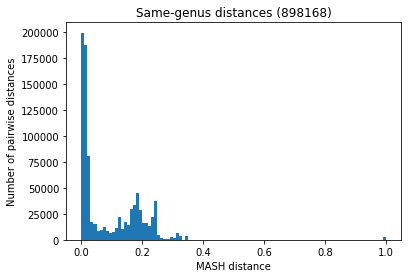

In [36]:
X = [float(s) for s in same_genus]
n, bins, patches = plt.hist(X,bins=100)
plt.title("Same-genus distances (" + str(len(same_genus)) + ")")
plt.xlabel("MASH distance")
plt.ylabel("Number of pairwise distances")
plt.show()


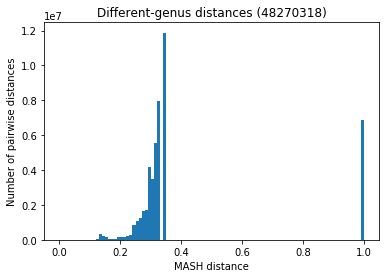

In [37]:
X = [float(s) for s in different_genus]
n, bins, patches = plt.hist(X,bins=100)
plt.title("Different-genus distances (" + str(len(different_genus)) + ")")
plt.xlabel("MASH distance")
plt.ylabel("Number of pairwise distances")
plt.show()


In [58]:
R = range(0,32)
tpr_points = []
fpr_points = []
precision = []
for th in R:
    th = th * 0.01
    TP = 1.0*sum([1 for x in same_genus if x <= th])/len(same_genus)
    FP = 1.0*sum([1 for x in different_genus if x <= th])/len(different_genus)
    tpr_points.append(TP)
    fpr_points.append(FP)
    #precision.append(1.0*sum([1 for x in same_species if x <= th])/(sum([1 for x in same_species if x <= th]) + sum([1 for x in different_species if x <= th])))


In [59]:
m_i = None
m = 0
score = [t + (1-f) for (t,f) in zip(tpr_points,fpr_points)]
for (i, s) in enumerate(score):
    if s > m: 
        m = s
        m_i = i
#print(precision[m_i])

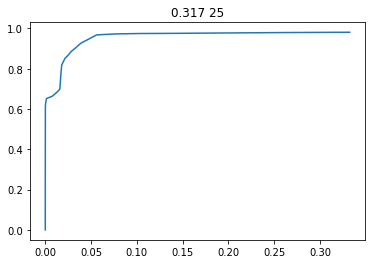

0.056070730671382775 0.9681284570369908


In [60]:
plt.plot(fpr_points, tpr_points)
plt.title(str(round(auc(fpr_points,tpr_points),3)) + " " + str(R[m_i]))
plt.show()      
print(fpr_points[m_i],tpr_points[m_i])

#### Species

In [31]:
same_species = []
different_species = []
for i in range(len(true_species_labels)):
    for j in range(i+1,len(true_species_labels)):
        if true_species_labels[i] == true_species_labels[j]:
            same_species.append(distance_matrix[i][j])
        else:
            different_species.append(distance_matrix[i][j])

In [33]:
print("Same species: %d" % len(same_species))
print("Different species: %d" % len(different_species))


Same species: 478451
Different species: 48690035


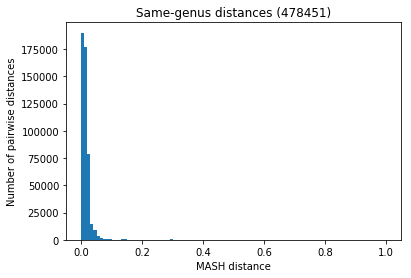

In [38]:
X = [float(s) for s in same_species]
n, bins, patches = plt.hist(X,bins=100)
plt.title("Same-genus distances (" + str(len(same_species)) + ")")
plt.xlabel("MASH distance")
plt.ylabel("Number of pairwise distances")
plt.show()

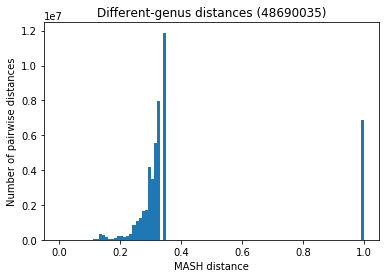

In [39]:
X = [float(s) for s in different_species]
n, bins, patches = plt.hist(X,bins=100)
plt.title("Different-genus distances (" + str(len(different_species)) + ")")
plt.xlabel("MASH distance")
plt.ylabel("Number of pairwise distances")
plt.show()


In [55]:
R = range(0,32)
tpr_points = []
fpr_points = []
precision = []
for th in R:
    th = th * 0.01
    TP = 1.0*sum([1 for x in same_species if x <= th])/len(same_species)
    FP = 1.0*sum([1 for x in different_species if x <= th])/len(different_species)
    tpr_points.append(TP)
    fpr_points.append(FP)
    #precision.append(1.0*sum([1 for x in same_species if x <= th])/(sum([1 for x in same_species if x <= th]) + sum([1 for x in different_species if x <= th])))


In [56]:
m_i = None
m = 0
score = [t + (1-f) for (t,f) in zip(tpr_points,fpr_points)]
for (i, s) in enumerate(score):
    if s > m: 
        m = s
        m_i = i
#print(precision[m_i])

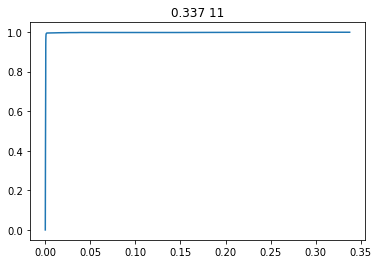

0.001688805522526324 0.9950444246119248


In [57]:
plt.plot(fpr_points, tpr_points)
plt.title(str(round(auc(fpr_points,tpr_points),3)) + " " + str(R[m_i]))
plt.show()      
print(fpr_points[m_i],tpr_points[m_i])

### Cluster distance (density)

#### Genus

In [63]:
distance_distr_genus = dict()
for row in range(len(distance_matrix)):
    for col in range(row+1,len(distance_matrix)):
        if true_genus_labels[row] == true_genus_labels[col]:
            t = true_genus_labels[row]
            try:
                distance_distr_genus[t].append(distance_matrix[row][col])
            except:
                distance_distr_genus[t] = [distance_matrix[row][col]]

In [64]:
classes = sorted(distance_distr_genus.keys())
K = [i for i in range(len(classes)) if len(distance_distr_genus[classes[i]]) > 2000 or classes[i] == "Cutibacterium"]


In [66]:
dataset = [distance_distr_genus[classes[k]] for k in K]

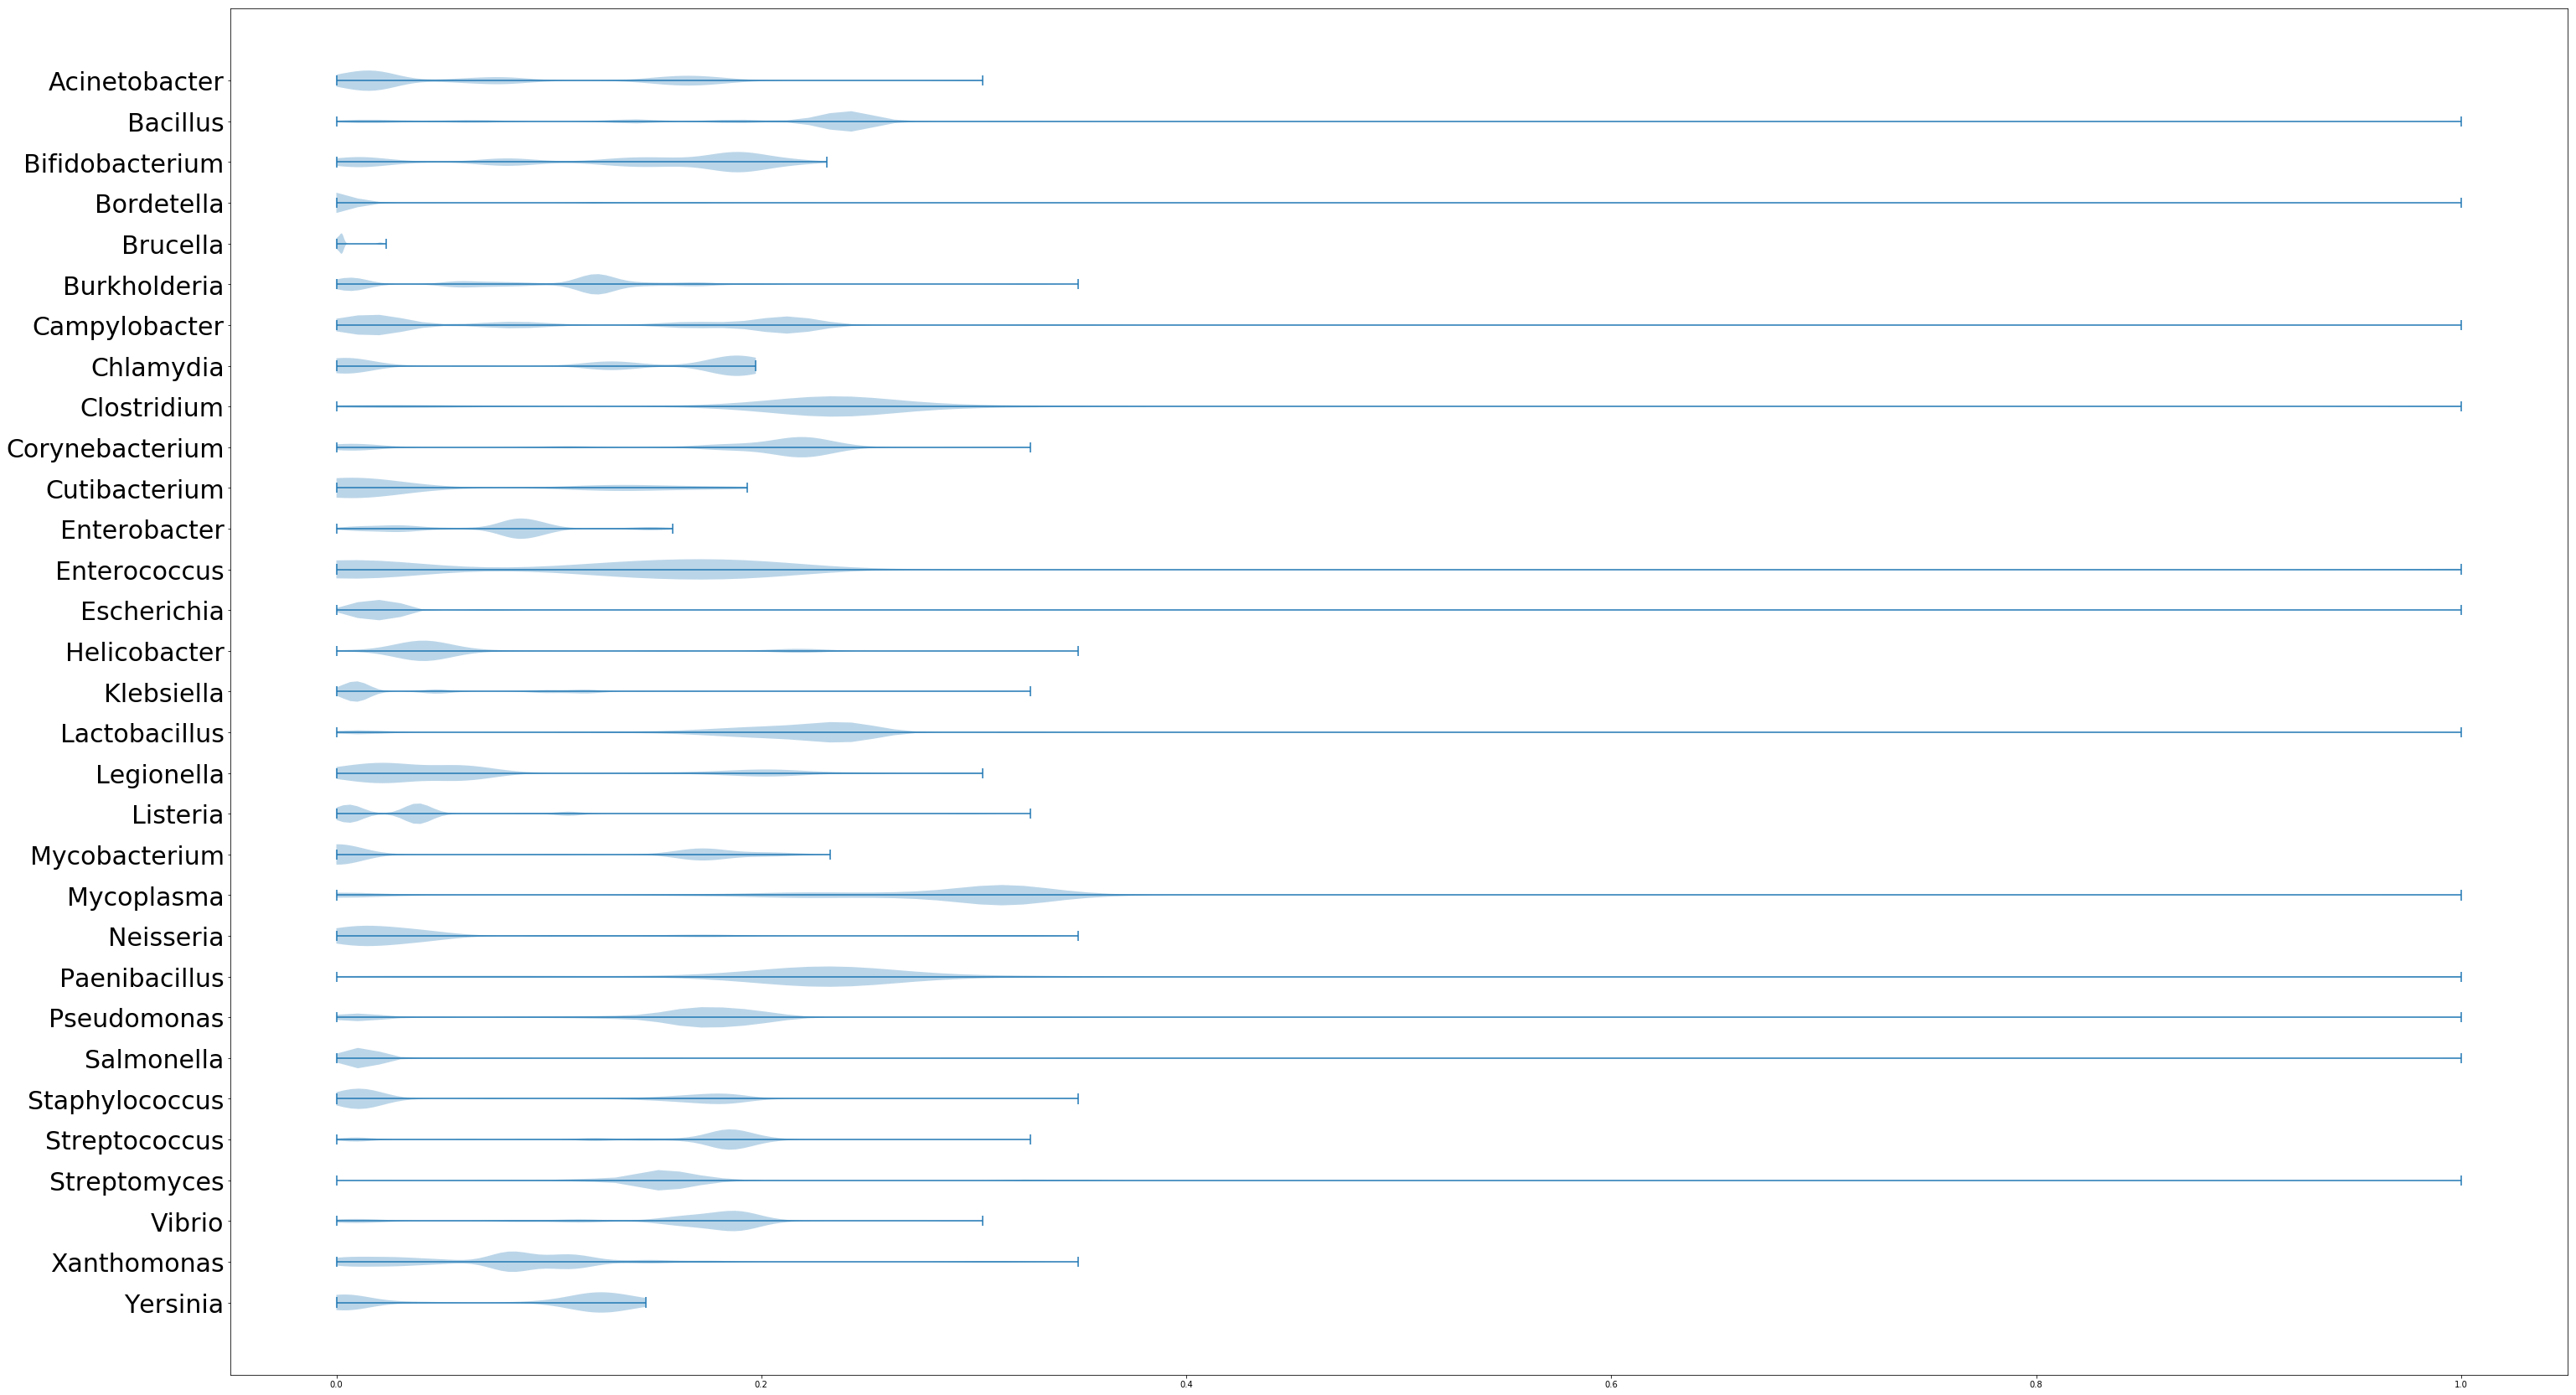

In [67]:
fig, axes = plt.subplots(figsize=(50,30))
axes.violinplot(dataset[::-1], vert=False)

labels = np.array(classes)[K][::-1]
axes.set_yticks(np.arange(1, len(labels) + 1))
axes.set_yticklabels(labels)
axes.tick_params('y',labelsize=30)

plt.show()

In [74]:
classes = sorted(distance_distr_genus.keys())
for c in classes:
    A = np.average(distance_distr_genus[c])
    S = np.std(distance_distr_genus[c])
    M = min(distance_distr_genus[c])
    X = max(distance_distr_genus[c])
    num_ones = sum([i > 0.99999 for i in distance_distr_genus[c]])

    print("\t".join([c, str(true_genus_labels.count(c)), str(A), str(S), str(M), str(X), str(num_ones)]))


Acetobacter	23	0.08518580151842686	0.06779166191122447	1.61292e-07	0.218622	0
Acholeplasma	4	0.20889816666666663	0.023746256135909555	0.167463	0.233439	0
Achromobacter	14	0.09544875329670328	0.033885567345509494	0.00830794	0.129989	0
Acidaminococcus	2	0.192549	0.0	0.192549	0.192549	0
Acidiphilium	2	0.0112807	0.0	0.0112807	0.0112807	0
Acidipropionibacterium	5	0.00831670411	0.0046375707787311	1.90491e-05	0.0119661	0
Acidithiobacillus	6	0.136638464	0.0832149439780894	0.00336217	0.207295	0
Acidovorax	9	0.13167664199166668	0.04106524528723255	7.72117e-05	0.163867	0
Acinetobacter	143	0.07380303088016615	0.07093026816474052	1.61292e-07	0.304307	0
Actinoalloteichus	5	0.139813862	0.05926391675185328	0.00260642	0.197726	0
Actinobacillus	10	0.09651026445155557	0.06891530636668743	3.71032e-06	0.201155	0
Actinomyces	11	0.2168826090909091	0.0575764318722743	0.0634185	0.313587	0
Actinoplanes	6	0.12518413110066667	0.0633258253634454	8.71321e-06	0.16828	0
Actinosynnema	2	0.0270687	0.0	0.0270687	0.02706

Enterococcus	83	0.12528098383822833	0.15901698564077105	6.45181e-07	1.0	82
Entomoplasma	4	0.18587849999999997	0.004553700061488456	0.180686	0.193313	0
Erwinia	10	0.1345844825311111	0.07579067577689977	5.12509e-05	0.249321	0
Erysipelothrix	5	0.08778687760000001	0.10638258077047388	0.000125241	0.218622	0
Erythrobacter	8	0.18502696285714287	0.04264234882917072	0.00107996	0.224163	0
Escherichia	592	0.02805586190687416	0.06746365619694611	0.0	1.0	589
Ethanoligenens	2	1.08119e-05	0.0	1.08119e-05	1.08119e-05	0
Eubacterium	5	0.21183607	0.10403975439385707	0.0406077	0.291228	0
Exiguobacterium	7	0.1869913947619048	0.09648481889678948	0.00969929	0.313587	0
Faecalibacterium	2	0.0249938	0.0	0.0249938	0.0249938	0
Fervidobacterium	4	0.1134391	0.03209789706273606	0.0494386	0.144623	0
Fibrobacter	2	6.60085e-05	0.0	6.60085e-05	6.60085e-05	0
Fictibacillus	2	0.140152	0.0	0.140152	0.140152	0
Filomicrobium	2	2.09698e-06	0.0	2.09698e-06	2.09698e-06	0
Flavobacterium	26	0.1934783959723077	0.06601815684608549	7

Rhodothermus	2	0.0324999	0.0	0.0324999	0.0324999	0
Rhodovulum	5	0.09253344020000001	0.0674266131367737	0.000612802	0.172308	0
Rickettsia	61	0.08028809485335901	0.07190198231441974	8.06482e-07	0.349025	0
Riemerella	10	0.017178825135999998	0.014422945938343031	7.42192e-06	0.0340063	0
Roseiflexus	2	0.174385	0.0	0.174385	0.174385	0
Roseobacter	3	0.0562796514	0.039731146199479705	9.13542e-05	0.0844229	0
Roseomonas	2	0.0560414	0.0	0.0560414	0.0560414	0
Rothia	4	0.10536843333333334	0.07061129250643192	0.026319	0.175998	0
Rubrobacter	2	0.208101	0.0	0.208101	0.208101	0
Ruegeria	2	0.197726	0.0	0.197726	0.197726	0
Rufibacter	3	0.17656800000000003	0.008161529554358468	0.170231	0.188091	0
Ruminiclostridium	13	0.1959462478217949	0.09384172301146196	1.37184e-05	0.304307	0
Ruminococcus	2	0.213896	0.0	0.213896	0.213896	0
Salinibacter	2	0.0115166	0.0	0.0115166	0.0115166	0
Salinispora	2	0.0978513	0.0	0.0978513	0.0978513	0
Salmonella	426	0.023468876150607977	0.07735976267930758	0.0	1.0	423
Selenomonas	5	0

#### Species

In [62]:
distance_distr_species = dict()
for row in range(len(distance_matrix)):
    for col in range(row+1,len(distance_matrix)):
        if true_species_labels[row] == true_species_labels[col]:
            t = true_species_labels[row]
            try:
                distance_distr_species[t].append(distance_matrix[row][col])
            except:
                distance_distr_species[t] = [distance_matrix[row][col]]

In [69]:
classes = sorted(distance_distr_species.keys())
K = [i for i in range(len(classes)) if len(distance_distr_species[classes[i]]) > 2000 or classes[i] == "Cutibacterium"]


In [70]:
dataset = [distance_distr_species[classes[k]] for k in K]

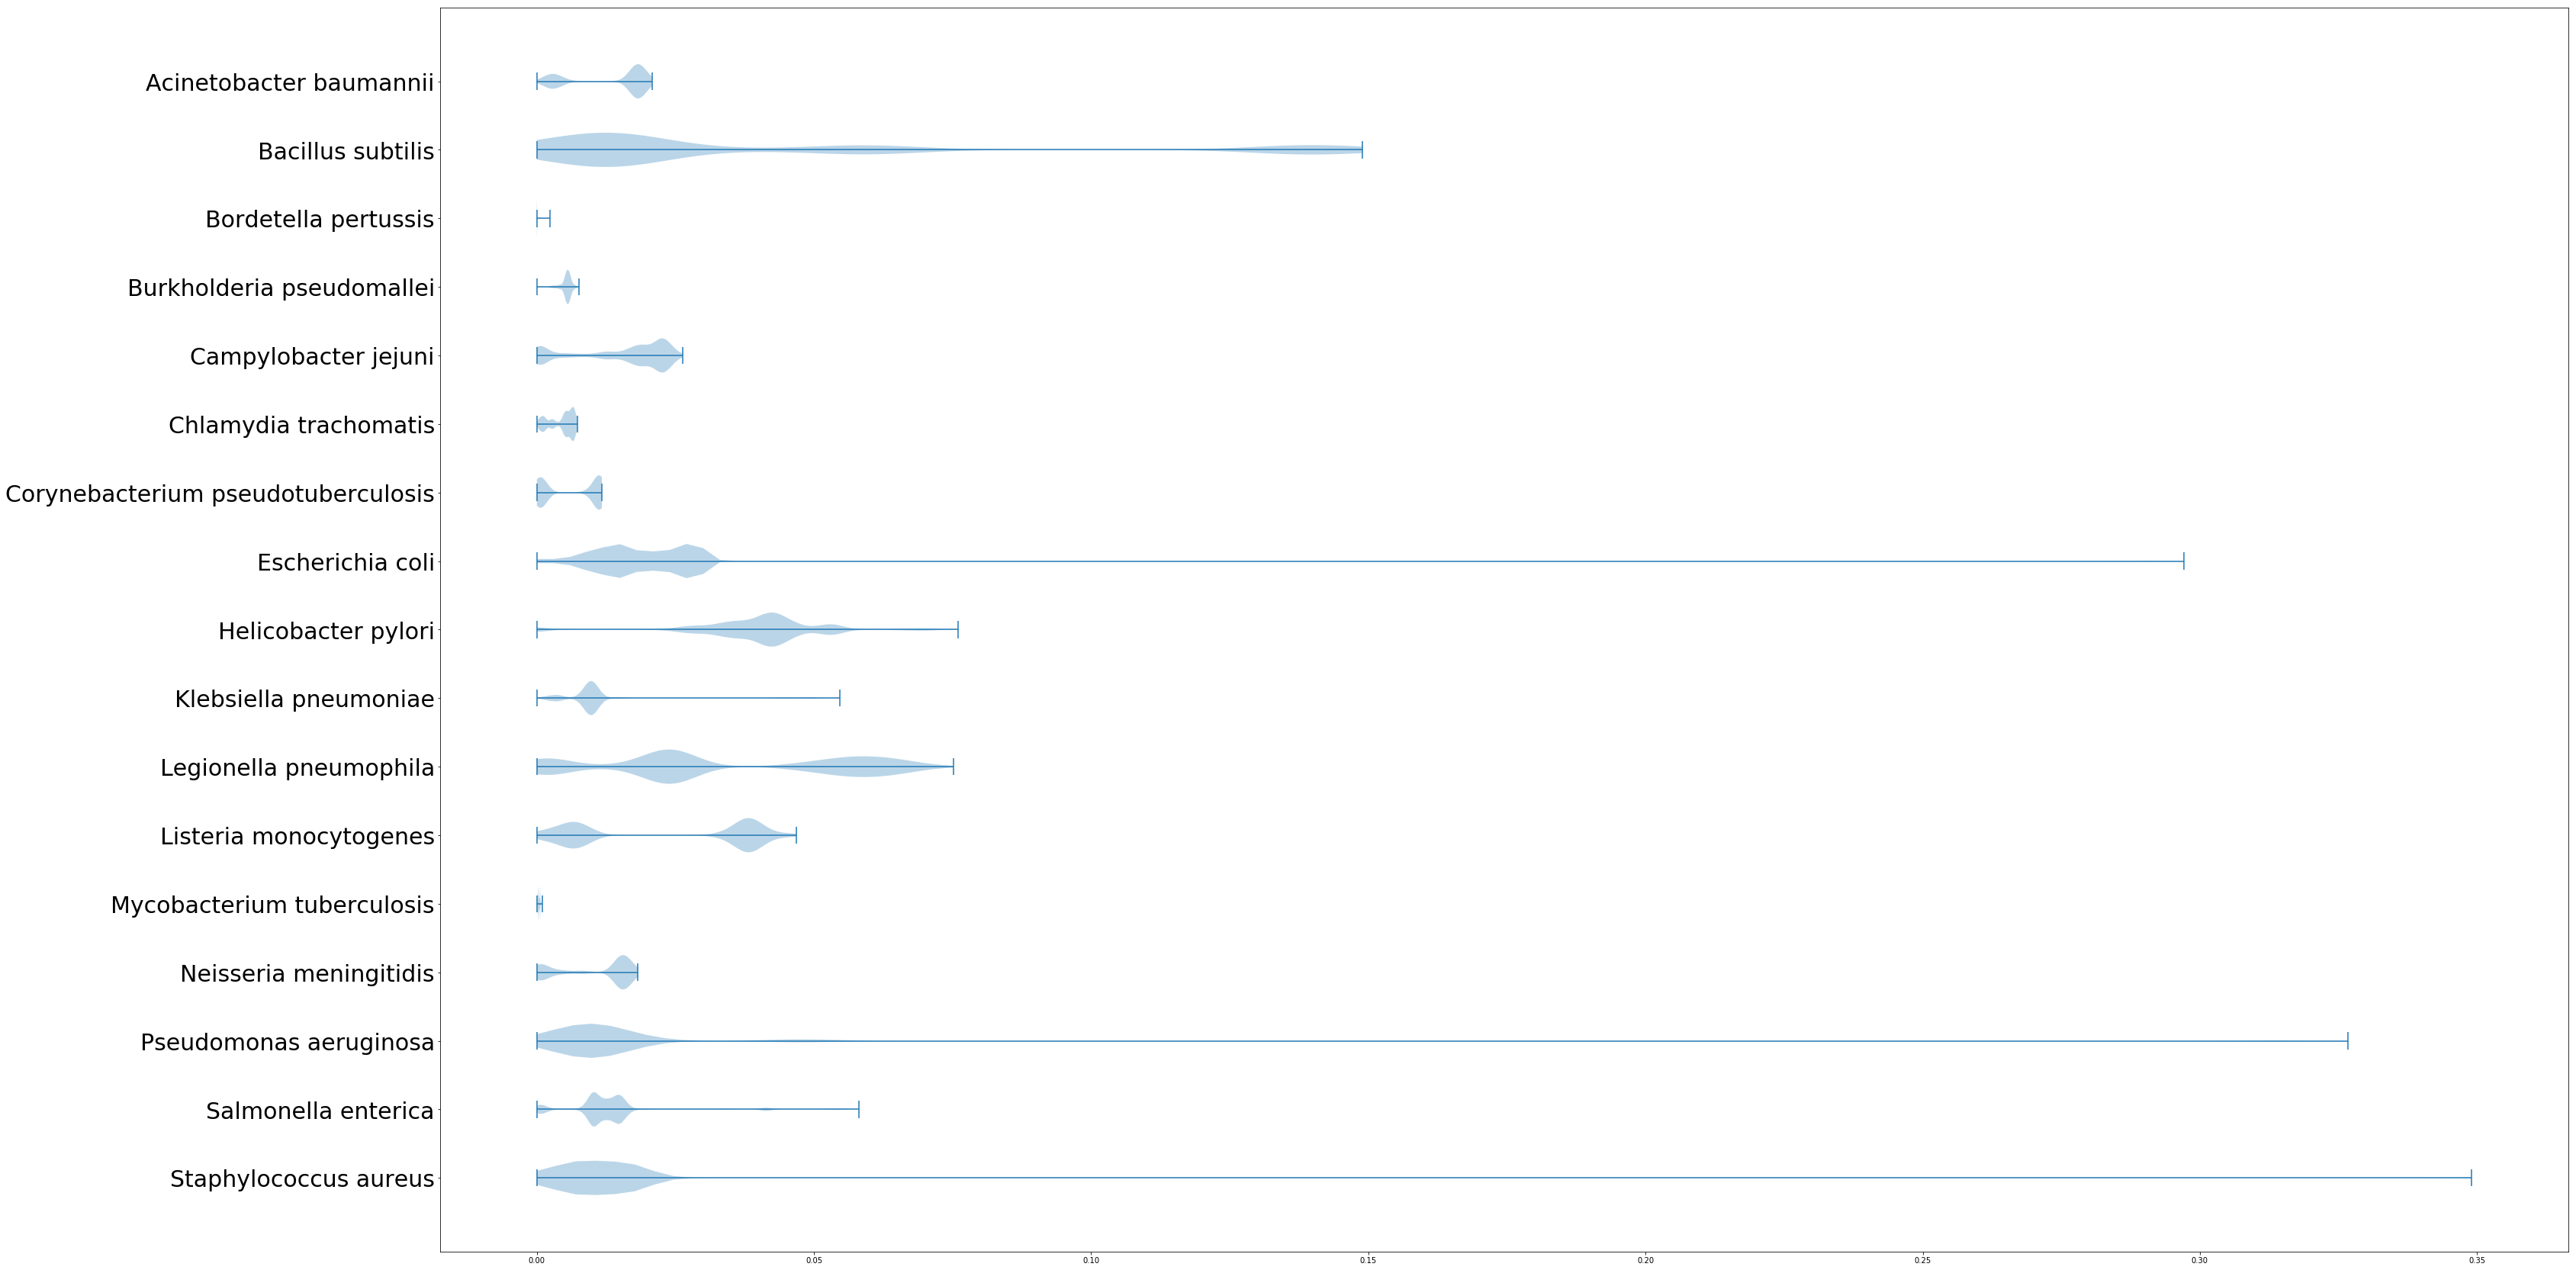

In [71]:
fig, axes = plt.subplots(figsize=(50,30))
axes.violinplot(dataset[::-1], vert=False)

labels = np.array(classes)[K][::-1]
axes.set_yticks(np.arange(1, len(labels) + 1))
axes.set_yticklabels(labels)
axes.tick_params('y',labelsize=30)

plt.show()

In [73]:
classes = sorted(distance_distr_species.keys())
for c in classes:
    A = np.average(distance_distr_species[c])
    S = np.std(distance_distr_species[c])
    M = min(distance_distr_species[c])
    X = max(distance_distr_species[c])
    num_ones = sum([i > 0.99999 for i in distance_distr_species[c]])

    print("\t".join([c, str(true_species_labels.count(c)), str(A), str(S), str(M), str(X), str(num_ones)]))


Acetobacter pasteurianus	17	0.03643187120707353	0.028460045941080942	1.61292e-07	0.0781704	0
Achromobacter denitrificans	2	0.107459	0.0	0.107459	0.107459	0
Achromobacter insolitus	2	0.0103837	0.0	0.0103837	0.0103837	0
Achromobacter spanius	2	0.118443	0.0	0.118443	0.118443	0
Achromobacter xylosoxidans	7	0.060925916666666656	0.03418116915344517	0.00830794	0.109066	0
Acidipropionibacterium acidipropionici	5	0.00831670411	0.0046375707787311	1.90491e-05	0.0119661	0
Acidithiobacillus caldus	3	0.0075672633333333334	0.002743208107360593	0.00372508	0.00995312	0
Acidithiobacillus ferrooxidans	2	0.00336217	0.0	0.00336217	0.00336217	0
Acidovorax citrulli	2	7.72117e-05	0.0	7.72117e-05	7.72117e-05	0
Acinetobacter baumannii	99	0.013252589328865597	0.007244040248393574	1.61292e-07	0.0207545	0
Acinetobacter calcoaceticus	2	0.095779	0.0	0.095779	0.095779	0
Acinetobacter haemolyticus	2	0.0160372	0.0	0.0160372	0.0160372	0
Acinetobacter junii	3	0.0182883	0.00299956578302038	0.0140467	0.0204612	0
Acinetobac

Campylobacter jejuni	130	0.015242325032601074	0.008507591890906892	9.67785e-07	0.0262757	0
Campylobacter lari	7	0.04206228571428572	0.01604636516138945	0.0162252	0.0664492	0
Campylobacter pinnipediorum	5	0.028367683999999997	0.01581382093446818	0.00544462	0.0417146	0
Campylobacter sputorum	4	0.025133926666666667	0.01372216992219363	0.00865006	0.0418762	0
Campylobacter subantarcticus	2	0.0103982	0.0	0.0103982	0.0103982	0
Candidatus Arthromitus sp. SFB-mouse	2	0.00103556	0.0	0.00103556	0.00103556	0
Candidatus Azobacteroides pseudotrichonymphae	2	0.200503	0.0	0.200503	0.200503	0
Candidatus Baumannia cicadellinicola	3	0.17929399999999998	0.0023087946350134007	0.177069	0.182476	0
Candidatus Endolissoclinum faulkneri	2	0.13834	0.0	0.13834	0.13834	0
Candidatus Filomicrobium marinum	2	2.09698e-06	0.0	2.09698e-06	2.09698e-06	0
Candidatus Kinetoplastibacterium blastocrithidii	2	3.02037e-05	0.0	3.02037e-05	3.02037e-05	0
Candidatus Kinetoplastibacterium crithidii	2	9.91649e-05	0.0	9.91649e-05	9.91

Escherichia coli	578	0.019712232439961733	0.017761119404928416	0.0	0.297109	0
Ethanoligenens harbinense	2	1.08119e-05	0.0	1.08119e-05	1.08119e-05	0
Eubacterium limosum	3	0.05964756666666667	0.013524341536980235	0.0406077	0.0707405	0
Faecalibacterium prausnitzii	2	0.0249938	0.0	0.0249938	0.0249938	0
Fervidobacterium pennivorans	2	0.0494386	0.0	0.0494386	0.0494386	0
Fibrobacter succinogenes	2	6.60085e-05	0.0	6.60085e-05	6.60085e-05	0
Flavobacterium columnare	4	0.029461769500000002	0.026138303936960303	0.000685387	0.0561269	0
Flavobacterium johnsoniae	2	0.121315	0.0	0.121315	0.121315	0
Flavobacterium psychrophilum	8	0.0024725383571428568	0.002600774802907837	7.0878e-05	0.0071332	0
Francisella noatunensis	8	0.013809506771428571	0.023733288751728823	2.77778e-05	0.055033	0
Francisella persica	2	5.95191e-05	0.0	5.95191e-05	5.95191e-05	0
Francisella philomiragia	3	0.036236333333333336	0.013447702404582807	0.0172226	0.0460889	0
Francisella tularensis	40	0.011522087004826922	0.014175418000037052

Salmonella enterica	417	0.01275942581423477	0.008042290569035125	0.0	0.0580993	0
Serratia fonticola	3	0.038186533333333335	0.0012943281715065752	0.0366915	0.0398487	0
Serratia liquefaciens	3	0.0108967	7.007595878758978e-05	0.0108217	0.0109903	0
Serratia marcescens	29	0.033241368196182265	0.013009100344184267	2.41963e-06	0.0471735	0
Serratia plymuthica	6	0.027391932	0.01683724037139032	0.00431581	0.0477993	0
Serratia sp. ATCC 39006	2	2.41963e-06	0.0	2.41963e-06	2.41963e-06	0
Shewanella baltica	9	0.02440384588888889	0.006168958687763581	0.000917432	0.0303526	0
Shewanella putrefaciens	2	0.0117036	0.0	0.0117036	0.0117036	0
Shigella dysenteriae	2	0.021754	0.0	0.021754	0.021754	0
Sinorhizobium americanum	2	0.0126735	0.0	0.0126735	0.0126735	0
Sinorhizobium fredii	5	0.06337994	0.03402477434106507	0.0138408	0.0996377	0
Sinorhizobium meliloti	23	0.008759948743952568	0.002810645783501278	7.42192e-06	0.0174311	0
Solibacillus silvestris	2	0.0146319	0.0	0.0146319	0.0146319	0
Sorangium cellulosum	3	0

### Distances

In [ ]:
taxon_level_classes = set(taxon_level_dict.values())
for true_class in taxon_level_classes:
    if true_class in TAXON_EXCLUDE: continue
    idx_keep = []
    for (i, name) in enumerate(labels):
        try:
            g = taxon_level_dict[name]
            if g == true_class: idx_keep.append(i)
        except:
            continue
    class_data = data[np.ix_(idx_keep,idx_keep)] #subset of matrix for this class's cluster
    max_mindist = 0
    all_dist = []
    for i in range(len(class_data[0])):
        d = 1
        for j in range(len(class_data[0])):
            if i > j:
                all_dist.append(class_data[i][j]) 
            if i != j and class_data[i][j] > 0:
                if class_data[i][j] < d: d = class_data[i][j]
        if d > max_mindist: max_mindist = d

    A = np.average(all_dist)
    S = np.std(all_dist)
    M = min(all_dist)
    X = max(all_dist)
    num_ones = sum([i > 0.99999 for i in all_dist])

    print("\t".join([true_class,str(len(class_data[0])),str(A),str(S),str(M),str(X),str(num_ones),str(max_mindist)]))


## Dimensionality reduction

In [147]:
def matrix_subset_name(name, label_set):
    idx = [i for (i,e) in enumerate(label_set) if e == name]
    return distance_matrix[np.ix_(idx,idx)]

def plot_MDS(M, title, color_encoding):
    mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=2)
    results = mds.fit(M)
    coords = results.embedding_
    plt.scatter(coords[:, 0], coords[:, 1], c=color_encoding)
    plt.title(title)
    plt.show()
    
def species_set_from_genus(G, genus_label_set, species_label_set):
    return [species_label_set[i] for (i,e) in enumerate(genus_label_set) if e == G]

def NN_set_name(name, label_set, NN_idx):
    idx = [i for (i,e) in enumerate(label_set) if e == name]
    return ["blue" if i in NN_idx else "red" for i in idx]

#### Genus

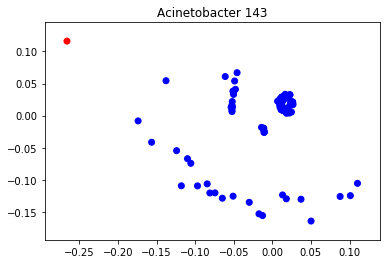

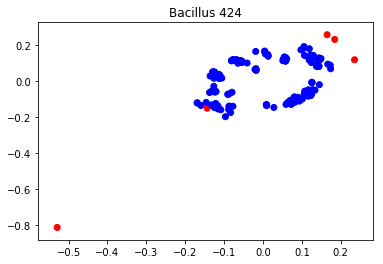

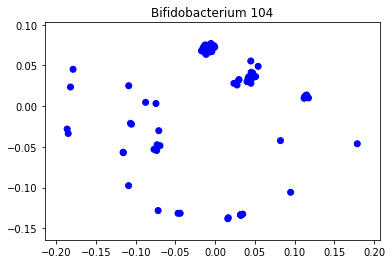

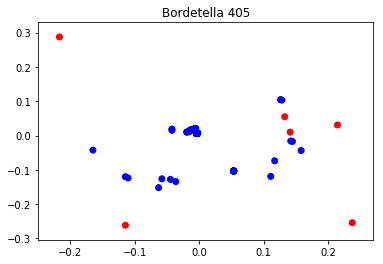

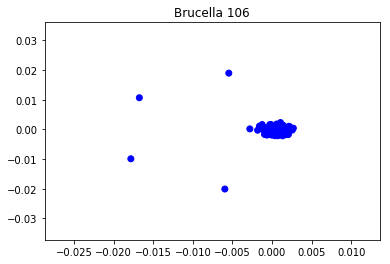

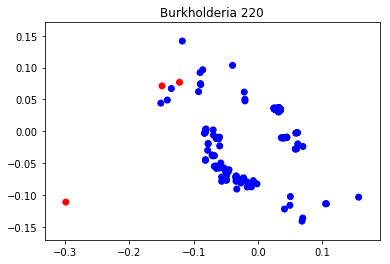

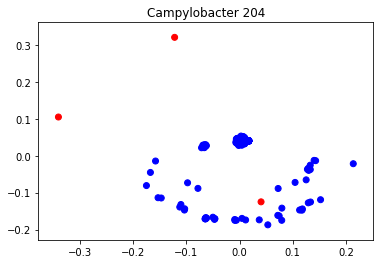

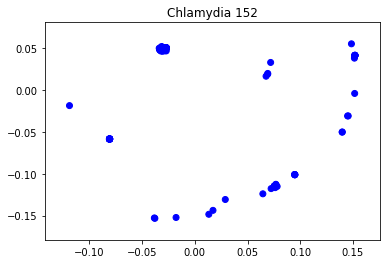

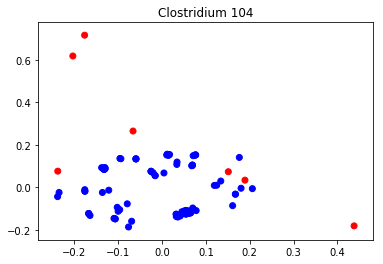

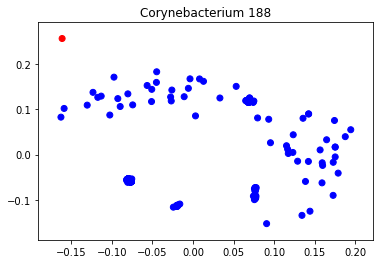

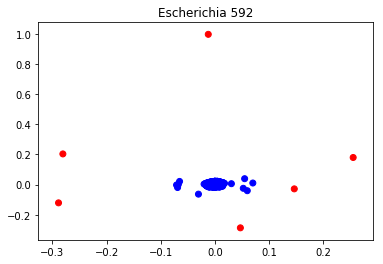

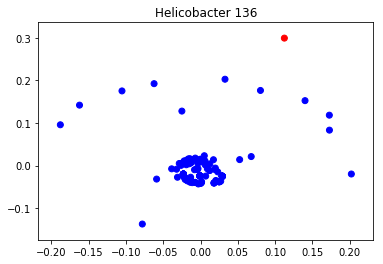

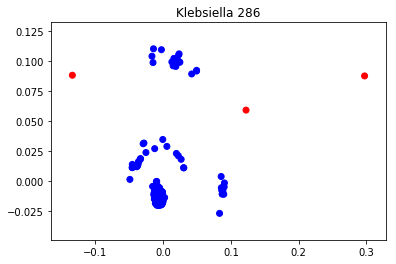

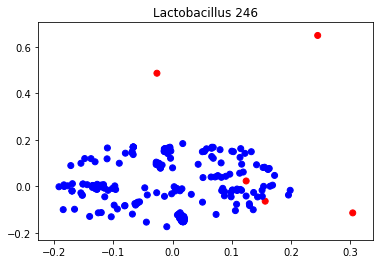

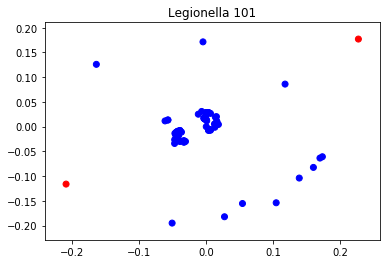

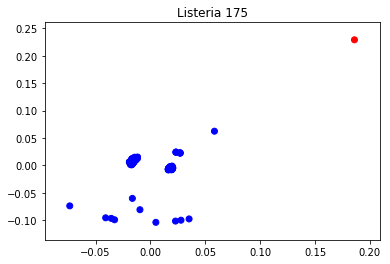

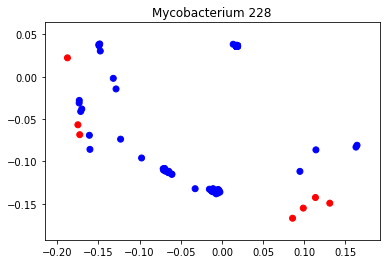

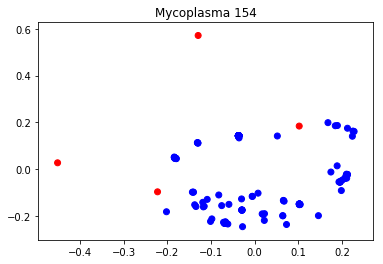

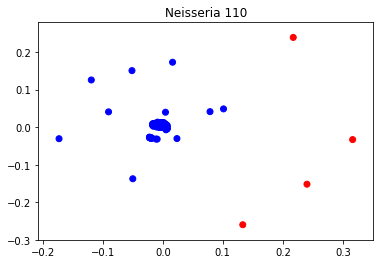

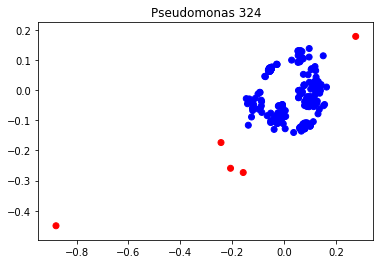

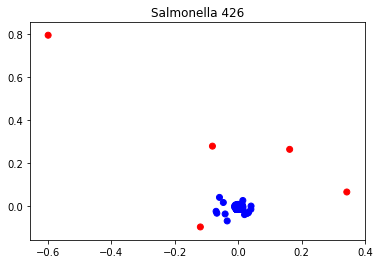

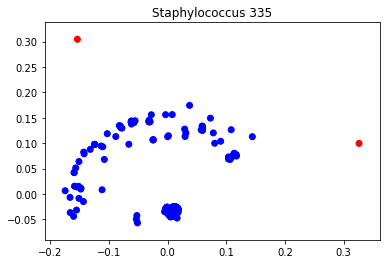

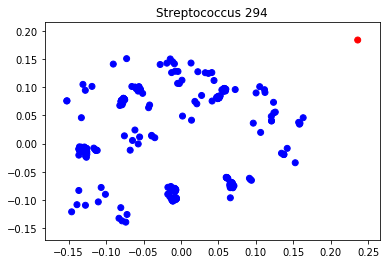

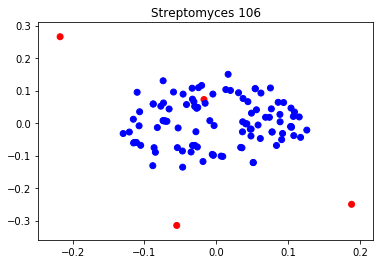

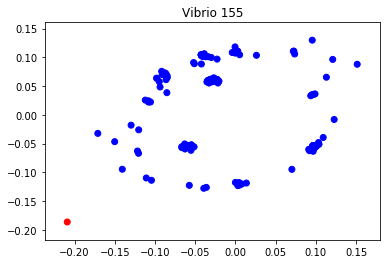

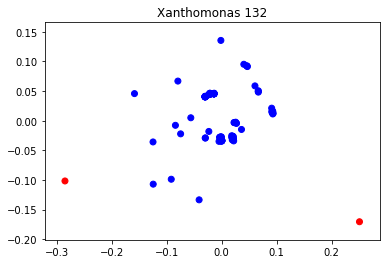

In [149]:
for (cls, count) in zip(col_classes_unique_genus, col_classes_counts_genus):
    if count > 100:
        M = matrix_subset_name(cls, true_genus_labels)
        lab = NN_set_name(cls, true_genus_labels, idx_genus_NN)
        plot_MDS(M, cls + " " + str(count), lab)
    

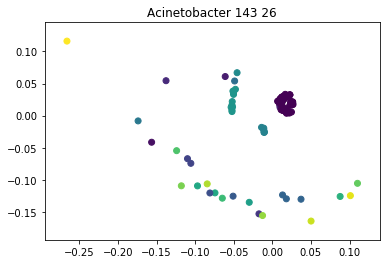

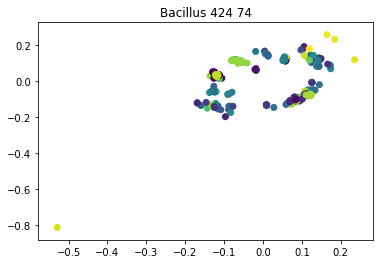

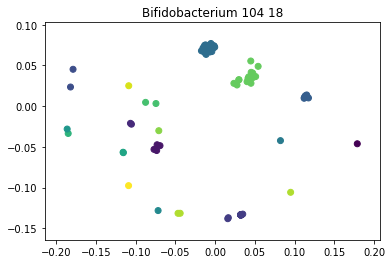

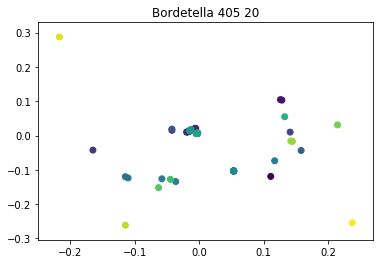

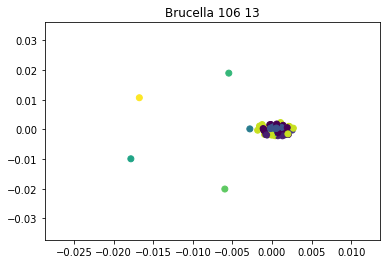

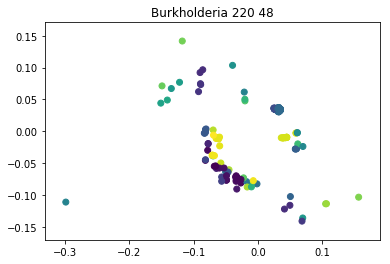

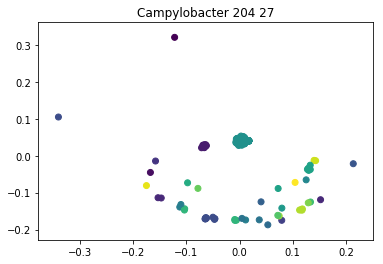

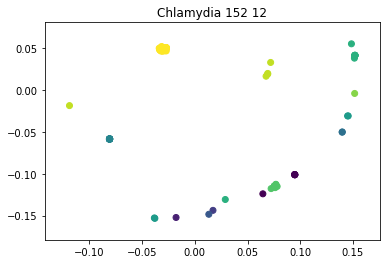

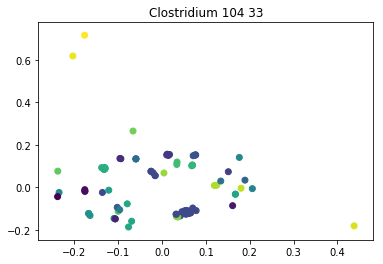

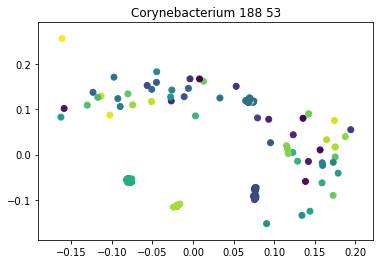

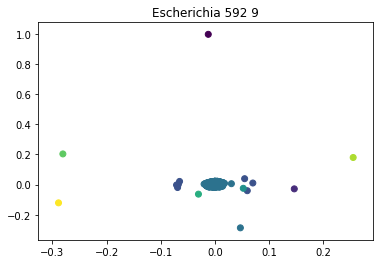

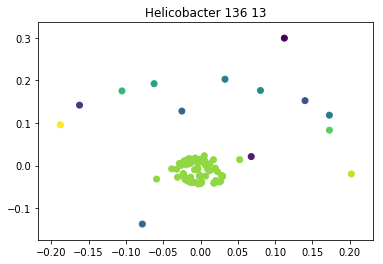

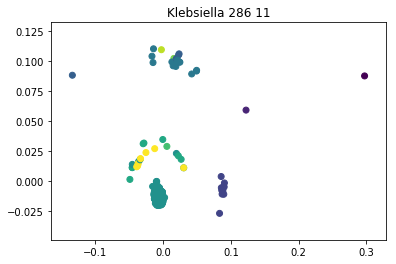

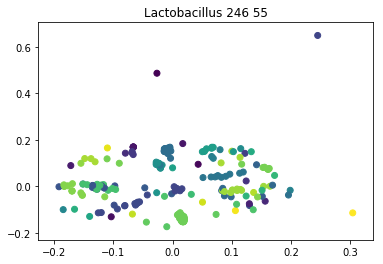

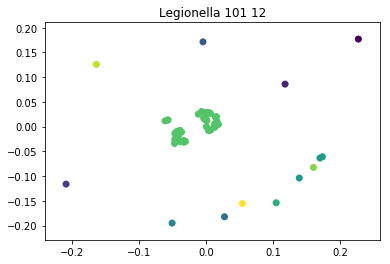

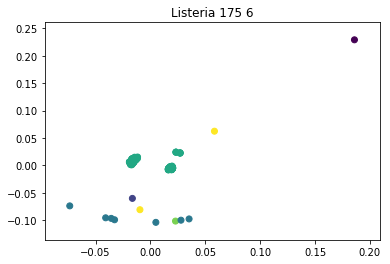

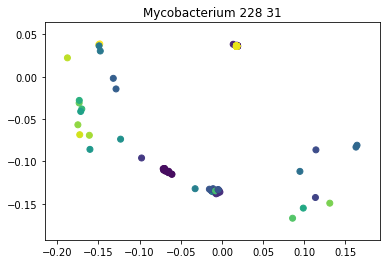

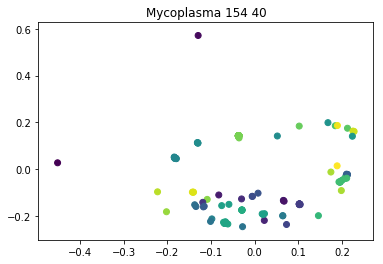

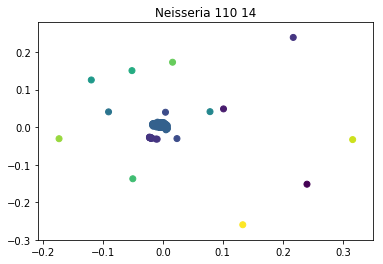

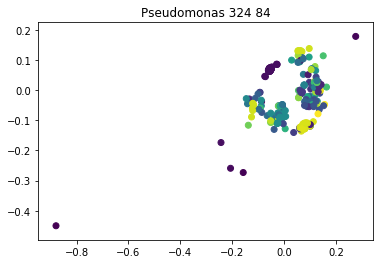

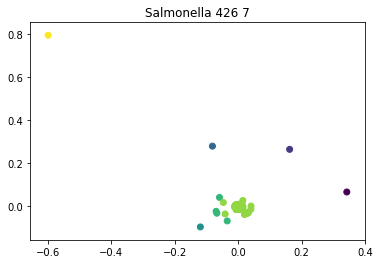

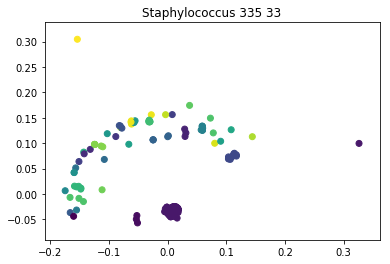

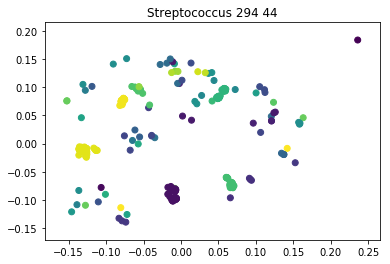

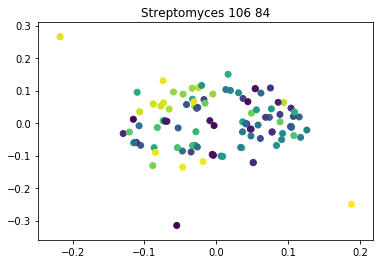

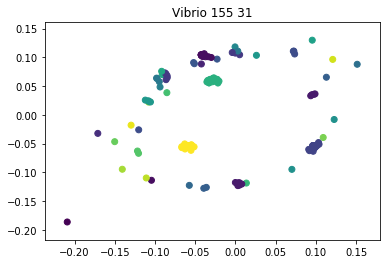

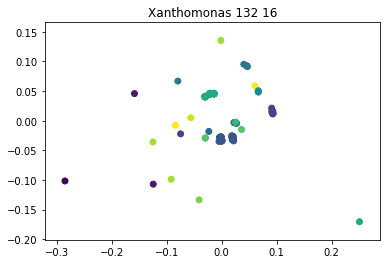

In [171]:
for (cls, count) in zip(col_classes_unique_genus, col_classes_counts_genus):
    if count > 100:
        M = matrix_subset_name(cls, true_genus_labels)
        lab = species_set_from_genus(cls, true_genus_labels, true_species_labels)
        le = LabelEncoder()
        le.fit(lab)
        lab = le.transform(lab)
        plot_MDS(M, cls + " " + str(count) + " " + str(len(le.classes_)), lab)
        

#### Species

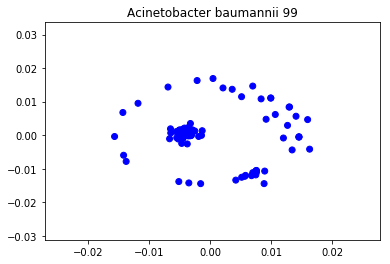

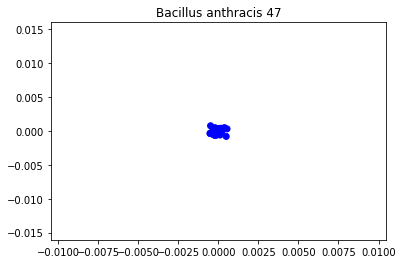

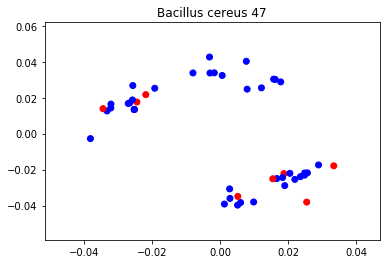

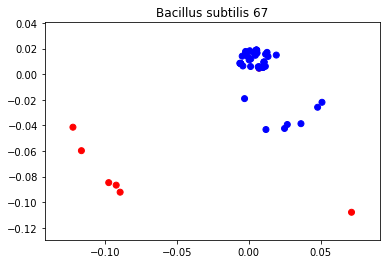

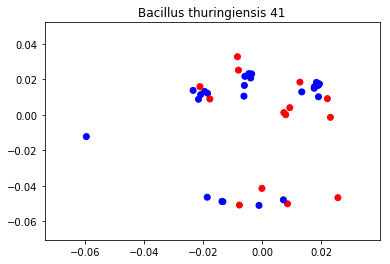

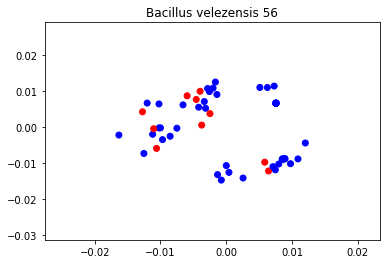

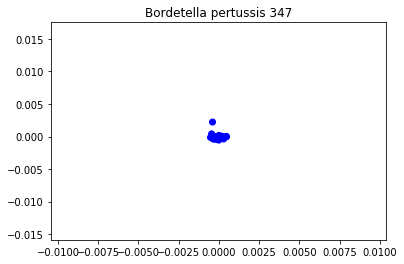

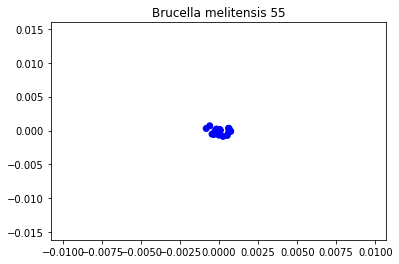

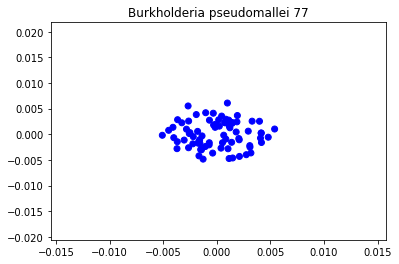

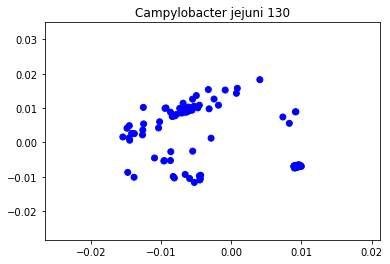

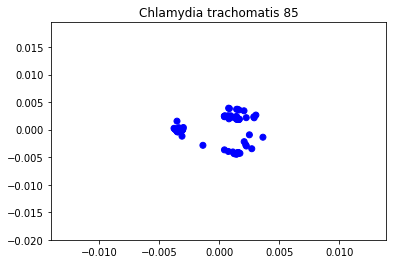

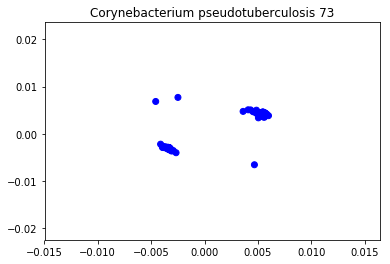

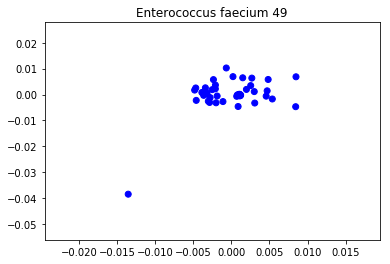

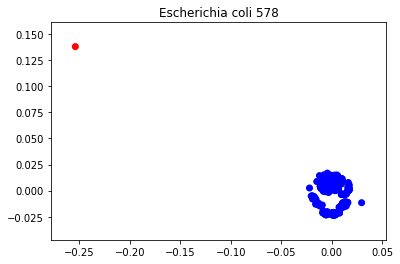

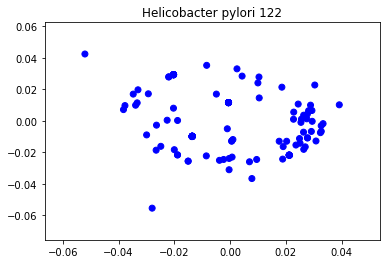

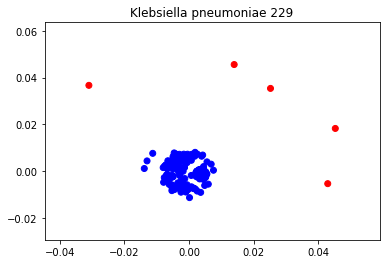

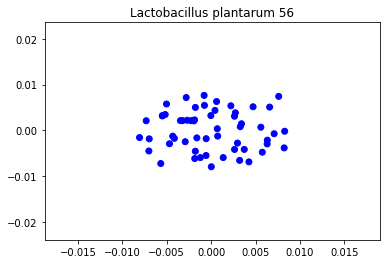

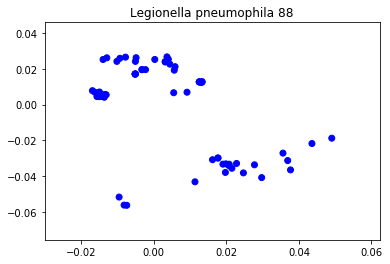

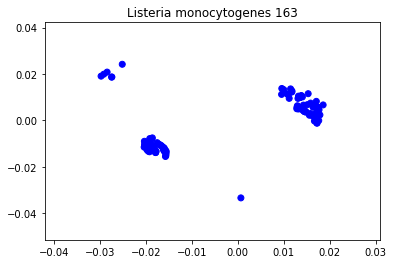

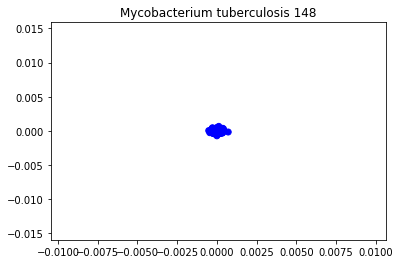

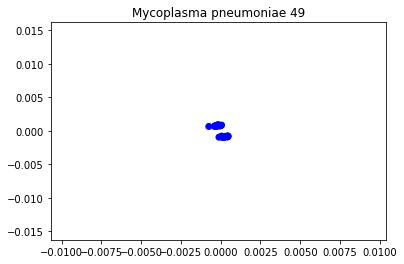

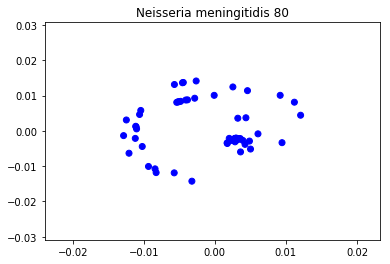

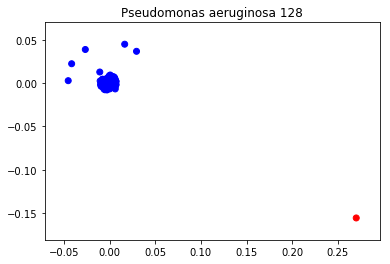

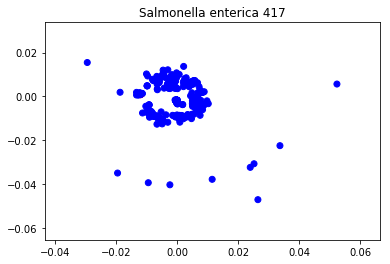

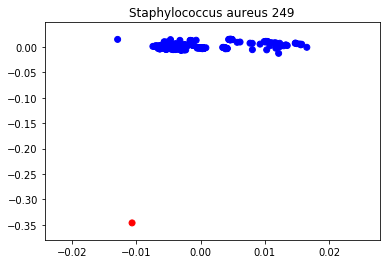

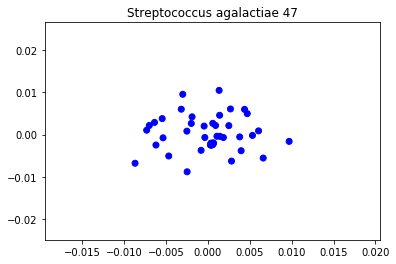

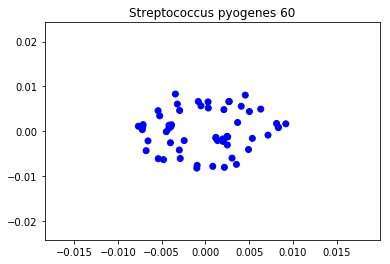

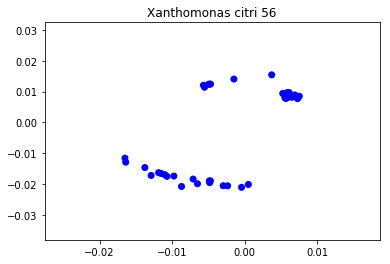

In [148]:
for (cls, count) in zip(col_classes_unique_species, col_classes_counts_species):
    if count > 40:
        M = matrix_subset_name(cls, true_species_labels)
        lab = NN_set_name(cls, true_species_labels, idx_species_NN)
        plot_MDS(M, cls + " " + str(count), lab)
        

## Clustering

### Functions

In [127]:
def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

### Dataset

In [134]:
#distArray = matrix_subset_name("Klebsiella pneumoniae", true_species_labels)

distArray = matrix_subset_name("Bifidobacterium", true_genus_labels)
df = pd.DataFrame(distArray)
row_clusters = linkage(squareform(distArray), metric='euclidean', method='complete')

### Visualization

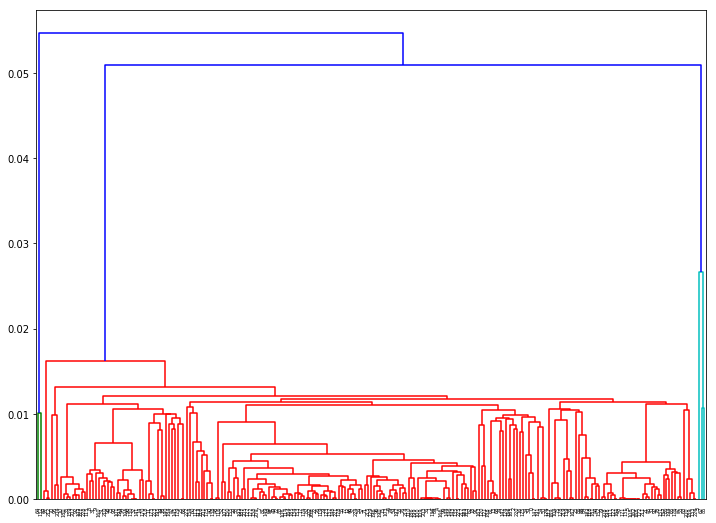

In [125]:
row_dendr = dendrogram(row_clusters)


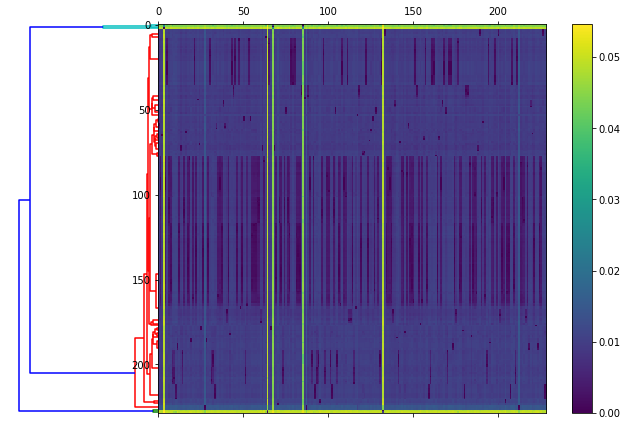

In [126]:
fig=plt.figure(facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='viridis')

axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)

Method:	 ward


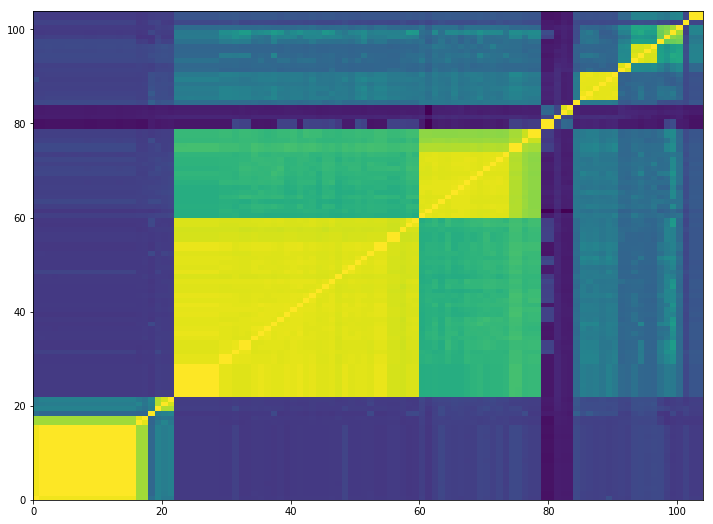

Method:	 single


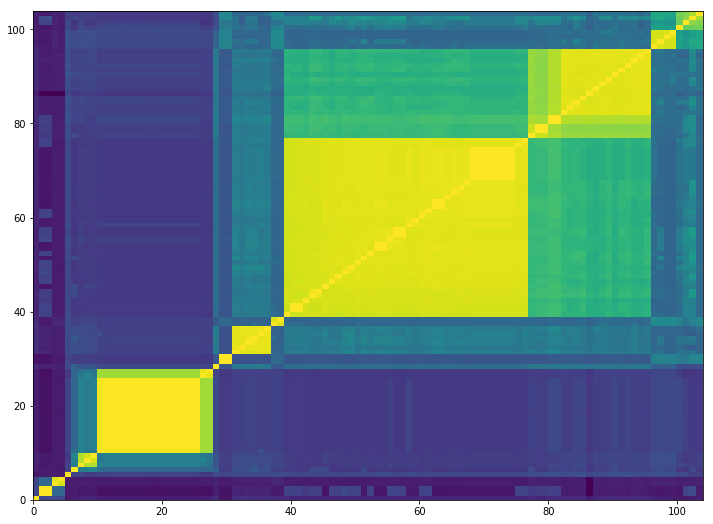

Method:	 average


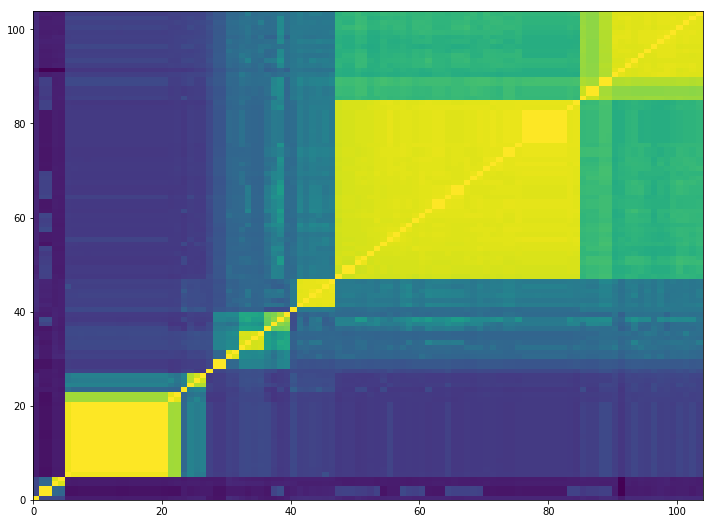

Method:	 complete


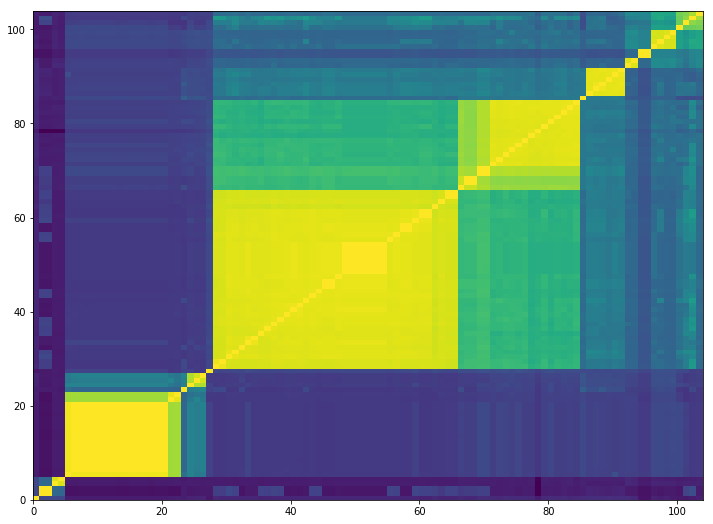

In [135]:
methods = ["ward","single","average","complete"]
for method in methods:
    print("Method:\t",method)
    
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(df.values,method)
    
    plt.pcolormesh(ordered_dist_mat, cmap='viridis_r')
    plt.xlim([0,len(ordered_dist_mat)])
    plt.ylim([0,len(ordered_dist_mat)])
    plt.show()